In [1]:
%load_ext autoreload
%autoreload 2

# Getting files and traces

In [23]:
from file_processing import get_netcdf_files, get_rhime_outs
from helpers import get_prior_samples

In [24]:
species = "sf6"
files = get_netcdf_files("/home/brendan/Documents/inversions/plotting/sf6_best")
outs = get_rhime_outs(files)

In [25]:
def get_prior_from_attrs(x):
    prior = {}
    split = x.split(",")
    for k, v in zip(split[::2], split[1::2]):
        prior[k] = v if k == "pdf" else float(v)
    return prior

In [26]:
outs[0]

<xarray.Dataset>
Dimensions:            (nmeasure: 877, draw: 10000, nparam: 97, nBC: 16,
                        nsigma_site: 8, nsigma_time: 4, nsite: 6, lat: 293,
                        lon: 391, countrynames: 20)
Coordinates:
  * draw               (draw) int64 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
  * nBC                (nBC) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * nmeasure           (nmeasure) int64 0 1 2 3 4 5 ... 871 872 873 874 875 876
    nsites             (nsite) int64 ...
  * nsigma_time        (nsigma_time) int64 0 1 2 3
  * nsigma_site        (nsigma_site) int64 0 1 2 3 4 5 6 7
  * lat                (lat) float32 10.73 10.96 11.2 ... 78.59 78.82 79.06
  * lon                (lon) float32 -97.9 -97.55 -97.2 ... 38.68 39.03 39.38
  * countrynames       (countrynames) <U14 'None' 'RestEU' ... 'UNITED KINGDOM'
  * nparam             (nparam) int64 0 1 2 3 4 5 6 7 ... 90 91 92 93 94 95 96
Dimensions without coordinates: nsite
Data variables: (12/35)
    Yobs               (nmeasure) float64 ...
    Yerror             (nmeasure) float64 ...
    Ytime              (nmeasure) datetime64[ns] ...
    Yapriori           (nmeasure) float64 ...
    Ymodmean           (nmeasure) float64 ...
    Ymodmedian         (nmeasure) float64 ...
    ...                 ...
    countrymode        (countrynames) float64 ...
    countrysd          (countrynames) float64 ...
    countryapriori     (countrynames) float64 ...
    countrydefinition  (lat, lon) int32 ...
    xsensitivity       (nmeasure, nparam) float64 ...
    bcsensitivity      (nmeasure, nBC) float64 ...
Attributes: (12/15)
    Start date:           2020-06-01
    End date:             2020-07-01
    Latent sampler:       mc.nuts.NUTS 
    Hyper sampler:        licer.Slice o
    Burn in:              10000
    Tuning steps:         10000
    ...                   ...
    Model error Prior:    pdf,uniform,lower,0.1,upper,1.0
    BCs Prior:            pdf,truncatednormal,mu,1.0,sigma,0.03,lower,0.0
    Creator:              bm13805
    Date created:         2024-01-09 10:33:53.036470
    Convergence:          Passed
    Repository version:

In [27]:
sampling_kwargs = dict(xprior = get_prior_from_attrs(outs[0].attrs["Emissions Prior"]),
                       bcprior = get_prior_from_attrs(outs[0].attrs["BCs Prior"]),
                       min_model_error = 0.15)

In [37]:
prior_samples = [get_prior_samples(ds, **sampling_kwargs).prior.squeeze(drop=True) for ds in outs]

Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]
Sampling: [bc, sigma, x, ymod, ymodbc]


In [38]:
prior_samples[0]

<xarray.Dataset>
Dimensions:      (draw: 1000, nmeasure: 877, nparam: 97, nsigma_site: 8,
                  nsigma_time: 4, nBC: 16)
Coordinates:
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * nmeasure     (nmeasure) int64 0 1 2 3 4 5 6 ... 870 871 872 873 874 875 876
  * nparam       (nparam) int64 0 1 2 3 4 5 6 7 8 ... 88 89 90 91 92 93 94 95 96
  * nsigma_site  (nsigma_site) int64 0 1 2 3 4 5 6 7
  * nsigma_time  (nsigma_time) int64 0 1 2 3
  * nBC          (nBC) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    ymodbc       (draw, nmeasure) float64 10.3 9.96 10.09 ... 10.47 10.43 10.73
    x            (draw, nparam) float64 0.2386 0.1629 0.08813 ... 1.199 2.685
    sigma        (draw, nsigma_site, nsigma_time) float64 0.8006 ... 0.6932
    ymod         (draw, nmeasure) float64 10.24 10.12 10.24 ... 10.76 10.72
    bc           (draw, nBC) float64 0.9766 1.016 1.007 ... 0.9546 1.008 0.9952
Attributes:
    created_at:                 2024-01-19T15:36:06.506997
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.0

# Checking if inversions Y errors are calculated correctly...

In [54]:
import arviz as az
import pymc as pm
import xarray as xr

In [44]:
trace = az.InferenceData.from_netcdf("/home/brendan/Documents/inversions/plotting/sf6_best/trace_hbmcmc_output_2020-06-01.nc")

In [41]:
hbmcmc = xr.open_dataset("/home/brendan/Documents/inversions/plotting/sf6_best/SF6_EUROPE_hbmcmc_output_2020-06-01.nc")

In [45]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [51]:
from helpers import get_rhime_model

In [52]:
model = get_rhime_model(hbmcmc, bc_name="xbc", sigma_name="sig", **sampling_kwargs)

In [53]:
model

     x ~ TruncatedNormal(-1.71e+03, 41.3, 0, inf)
   xbc ~ TruncatedNormal(1, 0.03, 0, inf)
   sig ~ Uniform(0.1, 1)
ymodbc ~ Normal(f(xbc), f(sig, x))
  ymod ~ Normal(f(x, xbc), f(sig, x))

In [59]:
post_pred = pm.sample_posterior_predictive(trace, model=model, var_names=["ymodbc", "ymod"])

Sampling: [ymod, ymodbc]


In [60]:
post_pred

Inference data with groups:
	> posterior_predictive

## Plotting

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [63]:
colors = ['navy','firebrick','dodgerblue','darkorange']
font = {'size':12}
plt.rc('font', **font)

In [64]:
def plot_timeseries(time, values, uncert_lower=None, uncert_upper=None, color=None, label=None, ax=None, monthly=True, errorbar=True, **kwargs):
    """Plot time series"""
    if ax is None:
        ax = plt.gca()
    plot_kwargs = kwargs
    if color:
        plot_kwargs['color'] = color
    if label:
        plot_kwargs['label'] = label
    if monthly:
        time = time.astype('datetime64[M]')
    ax.plot(time, values, **plot_kwargs)
    if label:
        del plot_kwargs['label']
    if uncert_lower is not None and uncert_upper is not None:
        if errorbar:
            ax.errorbar(time, values, yerr=[values - uncert_lower, uncert_upper - values], marker='o', alpha=0.6, **plot_kwargs)
        ax.fill_between(time, uncert_lower, uncert_upper, alpha=0.2, **plot_kwargs)

In [68]:
filt = hbmcmc.siteindicator == 0
hbmcmc0 = hbmcmc.where(filt, drop=True)
post_pred0 = post_pred.posterior_predictive.ymod.where(filt, drop=True)

In [71]:
pp_mean = post_pred0.mean(["chain", "draw"])
pp_hdi = az.hdi(post_pred0, 0.68)

In [78]:
pp_mean

<xarray.DataArray 'ymod' (nmeasure: 180)>
array([10.42212548, 10.43319539, 10.42945051, 10.43356498, 10.42641822,
       10.41843514, 10.42003664, 10.42680135, 10.46604074, 10.446314  ,
       10.45271176, 10.44393679, 10.44539807, 10.4509648 , 10.43087613,
       10.42763362, 10.42803676, 10.42692588, 10.44283664, 10.43309891,
       10.43276386, 10.44124382, 10.44080105, 10.43020723, 10.43299329,
       10.43540479, 10.4304938 , 10.43079629, 10.43279571, 10.43376993,
       10.43567784, 10.43358953, 10.44250419, 10.44152868, 10.43745181,
       10.42951087, 10.42671406, 10.45611478, 10.43635907, 10.43682307,
       10.4350172 , 10.4337117 , 10.43216424, 10.46426055, 10.43660728,
       10.4373751 , 10.44071826, 10.42738783, 10.42816033, 10.43613207,
       10.43868391, 10.45470608, 10.47814721, 10.47452223, 10.46591243,
       10.4503439 , 10.45799491, 10.46547448, 10.46466952, 10.43367373,
       10.42121702, 10.42950458, 10.4307914 , 10.43655326, 10.44794017,
       10.45447934, 10.44844471, 10.44974498, 10.46245073, 10.45957329,
       10.45499417, 10.53545204, 10.69274771, 10.70472843, 10.70813221,
       10.6062993 , 10.61081541, 10.6027855 , 10.53869551, 10.55512954,
       10.62711934, 10.63195325, 10.621631  , 10.61558529, 10.59416188,
       10.60233079, 10.62778609, 10.60545945, 10.54734675, 10.53460269,
       10.53212919, 10.53834561, 10.5589734 , 10.53322913, 10.5088603 ,
       10.48984905, 10.503537  , 10.51885368, 10.50798198, 10.51069405,
       10.49411169, 10.48965484, 10.49361152, 10.49055474, 10.46620612,
       10.46822329, 10.48741584, 10.51087633, 10.52516699, 10.53782132,
       10.5445408 , 10.55471572, 10.50616186, 10.47965327, 10.47815992,
       10.48311511, 10.47075499, 10.49057035, 10.49446423, 10.50392685,
       10.52686937, 10.49554244, 10.48127311, 10.46630683, 10.4586729 ,
       10.45744316, 10.45846095, 10.48338704, 10.47807064, 10.47460752,
       10.48110762, 10.48345386, 10.48657064, 10.50010094, 10.49374357,
       10.48732313, 10.5028532 , 10.50487475, 10.50576196, 10.52453998,
       10.53135703, 10.52910448, 10.57643554, 10.59798846, 10.5167675 ,
       10.50982984, 10.51504088, 10.58435334, 10.66282169, 10.66212411,
       10.67471105, 10.68283794, 10.67548344, 10.68266827, 10.63037228,
       10.59237261, 10.47846574, 10.4985657 , 10.48581164, 10.48183676,
       10.45983699, 10.46292382, 10.47842422, 10.48740725, 10.49092644,
       10.48426374, 10.47230086, 10.4703873 , 10.47232503, 10.46250249,
       10.45876082, 10.46351175, 10.47177574, 10.48028702, 10.49347277,
       10.49697499, 10.48260833, 10.47190035, 10.4699215 , 10.45982402])
Coordinates:
  * nmeasure    (nmeasure) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179
    measurenum  (nmeasure) int64 0 1 2 3 4 5 6 7 ... 173 174 175 176 177 178 179

Text(0.5, 0.98, 'Posterior predictives: RHIME vs. sampling posterior predictive')

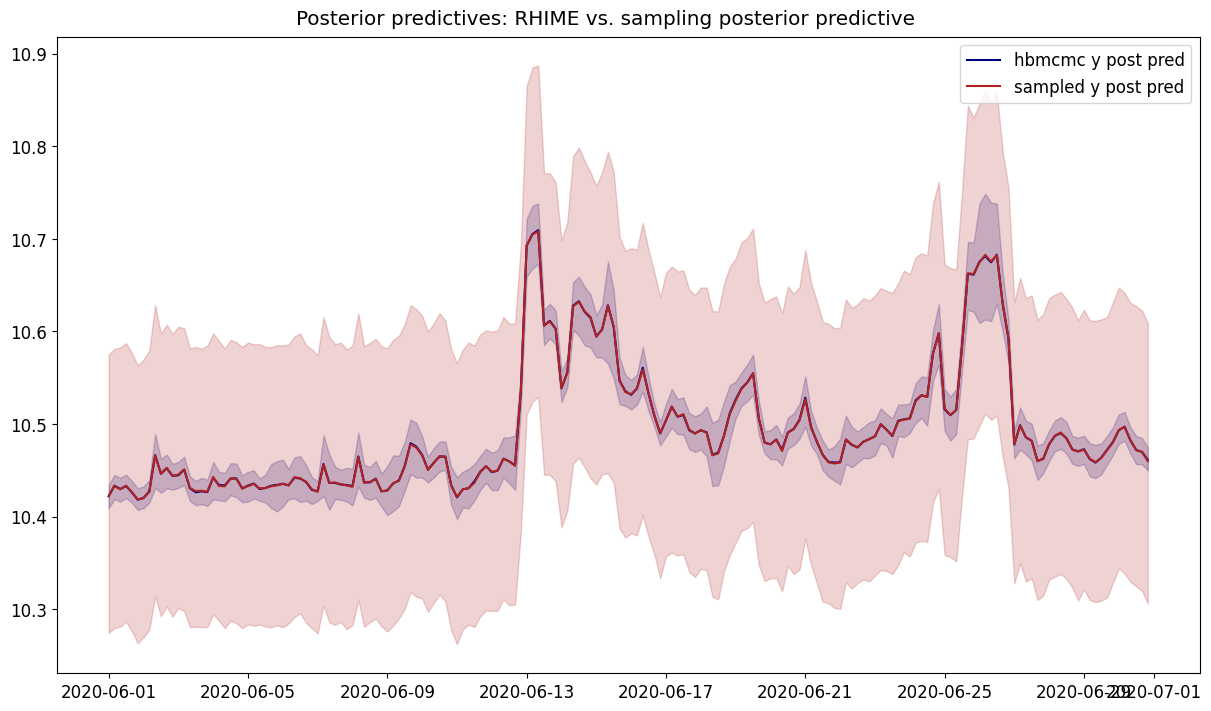

In [79]:
fig, ax = plt.subplots(1, figsize=(12,7), constrained_layout=True)

plot_timeseries(hbmcmc0.Ytime.values,
                hbmcmc0.Ymodmean.values,
                uncert_lower=hbmcmc0.Ymod68.isel(nUI=0),
                uncert_upper=hbmcmc0.Ymod68.isel(nUI=1),
                color=colors[0], label="hbmcmc y post pred", ax=ax, monthly=False, errorbar=False)
plot_timeseries(hbmcmc0.Ytime.values,
                pp_mean.values,
                uncert_lower=pp_hdi.ymod.isel(hdi=0).values,
                uncert_upper=pp_hdi.ymod.isel(hdi=1).values,
                color=colors[1], label="sampled y post pred", ax=ax, monthly=False, errorbar=False)
                        
ax.legend()

fig.suptitle("Posterior predictives: RHIME vs. sampling posterior predictive")